# Régression linéaire par morceau

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn.preprocessing 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import operator
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeRegressor 

c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import BDD


In [2]:
## Chargement des données énédis
#chemin jérémie
#enedis_final = pd.read_csv("/Users/jeremiedarracq/Stat-app/enedis_final.csv",sep=",")
#enedis_final = pd.read_csv("/Users/jeremiedarracq/Stat-app/enedis_final_3h.csv",sep=",")

#chemin elena
enedis_final = pd.read_csv("Données/enedis_final.csv",sep=",")

#chemin côme
#enedis = pd.read_csv("/Users/",sep=";")


In [3]:
## Chargement des données méteo + modification du noms des régions
#meteo_reg_df=pd.read_csv("/Users/jeremiedarracq/Stat-app/temperature_reg.csv",";")
meteo_reg_df=pd.read_csv("Données/temperature-quotidienne-regionale.csv",";")


## Récuperer toutes les régions de la BDD puis modification des noms
regions=meteo_reg_df["region"].unique()
regions=list(regions)

meteo_reg_df.loc[meteo_reg_df["region"]=="Nouvelle-Aquitaine","region"] = "Nouvelle Aquitaine"
meteo_reg_df.loc[meteo_reg_df["region"]=="Grand Est","region"] = "Grand-Est"


c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
enedis_final.columns

Index(['horodate', 'region_x', 'code_region', 'total_energie_soutiree_wh',
       'plage_de_puissance_souscrite', 'nb_points_soutirage',
       'jour_max_du_mois_0_1', 'semaine_max_du_mois_0_1', 'profil',
       'profil_type', 'date', 'code_reg', 'nom_reg', 'Ensemble',
       'conso_moyenne', 'Code', 'Libellé',
       'Part des "artisans, commerçants, chefs d'entreprise" dans la population 2018',
       'Part des "employés" dans la population 2018',
       'Part des "ouvriers" dans la population 2018',
       'Part des "retraités" dans la population 2018',
       'Part des "agriculteurs exploitants" dans la population 2018',
       'Part des "professions intermédiaires" dans la population 2018',
       'Part des "autres sans activité professionnelle" dans la population 2018',
       'Part des "autres sans activité professionnelle" dans la population 2018.1',
       'Part des "cadres et professions intellectuelles supérieures" dans la population 2018',
       'Médiane du revenu disponib

### Pré-processing

In [8]:
def pre_processing(bdd,region): ## rajouter meteo_reg si changement de bbdd
    enedis_region= bdd.loc[bdd.region_x == region]
    enedis_region_new = enedis_region.groupby("horodate")["total_energie_soutiree_wh"].sum().reset_index()
    #enedis_meteo_new = enedis_region.groupby("horodate")["Température (°C)_x"].mean().reset_index()
    #enedis_meteo_new["tmoy"] = enedis_meteo_new["Température (°C)_x"]
    enedis_region_new["date"]= enedis_region_new["horodate"].apply(lambda x : x[0:10])
    meteo_reg_region= meteo_reg_df[meteo_reg_df.region==region]
    enedis_prev_region = enedis_region_new.groupby("date")["total_energie_soutiree_wh"].sum().reset_index()
    enedis_prev_cleen = enedis_prev_region.merge(meteo_reg_region,on="date")

    #standardisation des données
    enedis_prev_cleen["tmoy_scaled"]=scale(enedis_prev_cleen["tmoy"])

    return enedis_prev_cleen

#pd.merge(enedis,socio,how='left',left_on="code_region",right_on="Code")

In [9]:
enedis_IDF = pre_processing(enedis_final,"Île-de-France")
enedis_HDF = pre_processing(enedis_final,"Hauts-de-France")
enedis_PACA = pre_processing(enedis_final,"Provence-Alpes-Côte d'Azur")
enedis_CVL = pre_processing(enedis_final,"Centre-Val de Loire")
enedis_Normandie = pre_processing(enedis_final,"Normandie")
enedis_Occitanie = pre_processing(enedis_final,"Occitanie")
enedis_ARA = pre_processing(enedis_final,"Auvergne-Rhône-Alpes")
enedis_BFC= pre_processing(enedis_final,"Bourgogne-Franche-Comté")
enedis_NA = pre_processing(enedis_final,"Nouvelle Aquitaine")
enedis_Bretagne = pre_processing(enedis_final,"Bretagne")
enedis_GE = pre_processing(enedis_final,"Grand-Est")
enedis_PDL = pre_processing(enedis_final,"Pays de la Loire")


## Calcul des seuils 

In [2]:
def calcul_seuil(df_reg):
    
    X = df_reg[["tmoy_scaled"]].to_numpy()
    Y = df_reg[["total_energie_soutiree_wh"]].to_numpy()

    model = DecisionTreeRegressor(random_state=0, max_depth=2)
    model.fit(X,Y)

    ## On trie les seuils
    th = list(sorted(set(model.tree_.threshold)))
    th += [(th[i] + th[i-1])/2 for i in range(1,len(th))]
    th = list(sorted(th))
    return(th[-1])


In [14]:
seuil_IDF=calcul_seuil(enedis_IDF)
seuil_HDF=calcul_seuil(enedis_HDF)
seuil_PACA=calcul_seuil(enedis_PACA)
seuil_CVL=calcul_seuil(enedis_CVL)
seuil_Normandie=calcul_seuil(enedis_Normandie)
seuil_Occitanie=calcul_seuil(enedis_Occitanie)
seuil_ARA=calcul_seuil(enedis_ARA)
seuil_BFC=calcul_seuil(enedis_BFC)
seuil_NA=calcul_seuil(enedis_NA)
seuil_Bretagne=calcul_seuil(enedis_Bretagne)
seuil_GE=calcul_seuil(enedis_GE)
seuil_PDL=calcul_seuil(enedis_PDL)

## Regression linéaire par morceaux 

In [15]:
def creation_df(df_region,seuil):

    ## Création des indicatrices
    Y = df_region["total_energie_soutiree_wh"].to_numpy()
    X = enedis_IDF["tmoy_scaled"].to_numpy()

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
    X_train_affiche=X_train
    X_test_affiche = X_test
    
    ## Indicatrice pour Train
    indicsupto_train= [ele if ele>seuil else 0 for ele in X_train]
    indicinfto_train= [ele if ele<=seuil else 0 for ele in X_train]

    ## Indicatrice pour Test
    indicsupto_test= [ele if ele>seuil else 0 for ele in X_test]
    indicinfto_test= [ele if ele<=seuil else 0 for ele in X_test]

    ##  Transformation en df pour l'échantillon train
    df_x1_train = pd.DataFrame(indicinfto_train, columns = ['Indicatrice < seuil'])
    df_x2_train = pd.DataFrame(indicsupto_train, columns = ['Indicatrice >= seuil'])

    X_train = pd.DataFrame(np.c_[df_x1_train["Indicatrice < seuil"],df_x2_train["Indicatrice >= seuil"]],columns = ["Indicatrice < seuil","Indicatrice >= seuil"])

    ##  Transformation en df pour l'échantillon test
    df_x1_test = pd.DataFrame(indicinfto_test, columns = ['Indicatrice < seuil'])
    df_x2_test = pd.DataFrame(indicsupto_test, columns = ['Indicatrice >= seuil'])

    X_test = pd.DataFrame(np.c_[df_x1_test["Indicatrice < seuil"],df_x2_test["Indicatrice >= seuil"]],columns = ["Indicatrice < seuil","Indicatrice >= seuil"])

    return(X_train,X_test,X_test_affiche,X_train_affiche,Y_train,Y_test)

In [16]:
## Création des échantillons d'apprentissages et de tests

X_train_ARA, X_test_ARA, X_test_affiche_ARA,X_train_affiche_ARA,Y_train_ARA, Y_test_ARA =creation_df(enedis_ARA,seuil_ARA)
X_train_IDF, X_test_IDF,X_test_affiche_IDF,X_train_affiche_IDF, Y_train_IDF, Y_test_IDF =creation_df(enedis_IDF,seuil_IDF)
X_train_PACA, X_test_PACA, X_test_affiche_PACA,X_train_affiche_PACA,Y_train_PACA, Y_test_PACA =creation_df(enedis_PACA,seuil_PACA)
X_train_HDF, X_test_HDF,X_test_affiche_HDF,X_train_affiche_HDF, Y_train_HDF, Y_test_HDF =creation_df(enedis_HDF,seuil_HDF)
X_train_NA, X_test_NA,X_test_affiche_NA,X_train_affiche_NA, Y_train_NA, Y_test_NA =creation_df(enedis_NA,seuil_NA)
X_train_GE, X_test_GE,X_test_affiche_GE,X_train_affiche_GE, Y_train_GE, Y_test_GE =creation_df(enedis_GE,seuil_GE)
X_train_Bretagne, X_test_Bretagne, X_test_affiche_Bretagne,X_train_affiche_Bretagne,Y_train_Bretagne, Y_test_Bretagne =creation_df(enedis_Bretagne,seuil_Bretagne)
X_train_CVL, X_test_CVL, X_test_affiche_CVL,X_train_affiche_CVL,Y_train_CVL, Y_test_CVL =creation_df(enedis_CVL,seuil_CVL)
X_train_BFC, X_test_BFC, X_test_affiche_BFC,X_train_affiche_BFC,Y_train_BFC, Y_test_BFC =creation_df(enedis_BFC,seuil_BFC)
X_train_Occitanie, X_test_Occitanie, X_test_affiche_Occitanie,X_train_affiche_Occitanie,Y_train_Occitanie, Y_test_Occitanie =creation_df(enedis_Occitanie,seuil_Occitanie)
X_train_Normandie, X_test_Normandie,X_test_affiche_Normandie,X_train_affiche_Normandier, Y_train_Normandie, Y_test_Normandie =creation_df(enedis_Normandie,seuil_Normandie)
X_train_PDL, X_test_PDL, X_test_affiche_PDL,X_train_affiche_PDL,Y_train_PDL, Y_test_PDL =creation_df(enedis_PDL,seuil_PDL)


### Création du modèle :

In [22]:
def modele_regression(X_train,X_test,X_test_affiche,Y_train,Y_test,df_region,region):

    Y = df_region["total_energie_soutiree_wh"].to_numpy()
    #X_train_sm = sm.add_constant(X_train)
    model = sm.OLS(Y_train,X_train).fit()
    print_model = model.summary()
    print(print_model)

    lm = LinearRegression(fit_intercept=True) 
    lm.fit(X_train, Y_train) 
    Y_predicted = lm.predict(X_test)


    # Évaluation du modèle
    rmse = mean_squared_error(Y_test, Y_predicted)
    r2 = r2_score(Y_test, Y_predicted)
    # Affichage des valeurs
    print("Pente : " ,lm.coef_)
    print("Ordonnée à l'origine : ", lm.intercept_)
    print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
    print('Sccore R2 : ', r2)
    
    # Tracée des valeurs
    # Points de données
    plt.scatter(enedis_IDF["tmoy_scaled"], Y, s=10)
    plt.xlabel('Température moyenne standardisée')
    plt.ylabel("Total d'energie soutiré en Méga Watt")
    plt.title("Regression par morceaux pour la région "+region)
    # Valeurs prédites
    plt.scatter(X_test_affiche, Y_predicted, color='r')
    plt.show()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.791
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                              656.8
Date:                Thu, 16 Feb 2023   Prob (F-statistic):                   1.08e-118
Time:                        17:14:44   Log-Likelihood:                         -8910.0
No. Observations:                 349   AIC:                                  1.782e+04
Df Residuals:                     347   BIC:                                  1.783e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

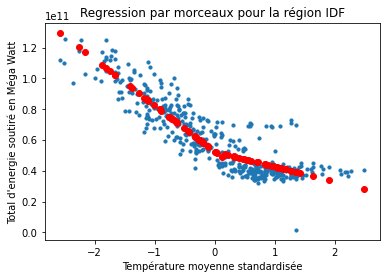

In [23]:
modele_regression(X_train_IDF,X_test_IDF,X_test_affiche_IDF,Y_train_IDF,Y_test_IDF,enedis_IDF,"IDF")

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.799
Model:                            OLS   Adj. R-squared (uncentered):              0.798
Method:                 Least Squares   F-statistic:                              690.1
Date:                Thu, 16 Feb 2023   Prob (F-statistic):                   1.16e-121
Time:                        17:15:13   Log-Likelihood:                         -8689.9
No. Observations:                 349   AIC:                                  1.738e+04
Df Residuals:                     347   BIC:                                  1.739e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

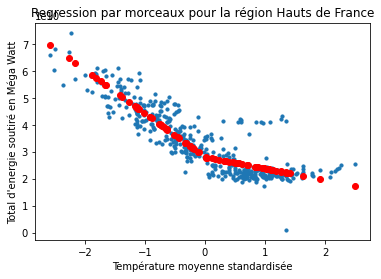

In [24]:
modele_regression(X_train_HDF,X_test_HDF,X_test_affiche_HDF,Y_train_HDF,Y_test_HDF,enedis_HDF,"Hauts de France")

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.758
Model:                            OLS   Adj. R-squared (uncentered):              0.757
Method:                 Least Squares   F-statistic:                              544.5
Date:                Thu, 16 Feb 2023   Prob (F-statistic):                   9.57e-108
Time:                        17:15:49   Log-Likelihood:                         -8792.6
No. Observations:                 349   AIC:                                  1.759e+04
Df Residuals:                     347   BIC:                                  1.760e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

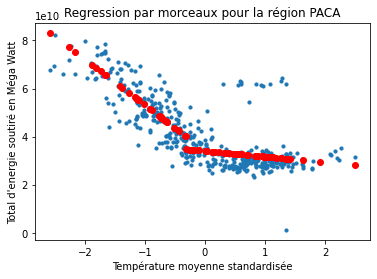

In [25]:
modele_regression(X_train_PACA,X_test_PACA,X_test_affiche_PACA,Y_train_PACA,Y_test_PACA,enedis_PACA,"PACA")